In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from scipy import sparse 
from importlib import reload
from matplotlib import pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import sys
#sys.path.append('/home/jma819/post_cmfe_analysis')
sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis')
import python_utils_jjm as utils_jjm
import dlc_utils
import caiman
import statsmodels.formula.api as smf
import scipy.spatial.distance as dist
import itertools
import math
import warnings
import numbers
from multiprocessing import Pool
import functools
warnings.filterwarnings(action='once')

/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of 

In [3]:
reload(utils_jjm)
reload(dlc_utils)

<module 'dlc_utils' from '/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/dlc_utils.py'>

In [6]:
cnmfe_file_key = pd.read_csv('/volumes/My_Passport/dlc_analysis/behavcamvideos/cnmfe_file_key.csv')
#cnmfe_file_key = pd.read_csv('/projects/p30771/dlc_analysis/openfield_dlc_output/cnmfe_file_key.csv')

In [7]:
cnmfe_base_dir = '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/'
#cnmfe_base_dir = '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/'
wt_CNMFE_file = ['30-Mar_20_39_05_out.mat', '30-Mar_20_45_16_out.mat', '27-Feb_17_33_59_out.mat', '22-Mar_22_52_02_out.mat',
                 '28-Feb_16_10_05_out.mat', '27-Feb_17_32_15_out.mat', '28-Feb_16_21_21_out.mat', '25-Mar_13_27_27_out.mat',
                 '25-Mar_14_22_02_out.mat', '25-Mar_14_22_44_out.mat', '26-Mar_18_33_55_out.mat', '27-Mar_00_26_12_out.mat', '27-Mar_00_48_46_out.mat']

ko_CNMFE_files = ['31-Mar_13_28_15_out.mat', '29-Mar_21_42_20_out.mat', '13-Apr_17_57_40_out.mat', '29-Mar_14_27_55_out.mat', '13-Apr_16_01_20_out.mat',
                 '13-Apr_16_11_27_out.mat', '29-Mar_13_39_44_out.mat']

In [8]:
tracking_files = ['/Volumes/My_Passport/dlc_analysis/behavcamvideos/open_field_miniscope/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in wt_CNMFE_file] 
#tracking_files = ['/projects/p30771/dlc_analysis/openfield_dlc_output/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in ko_CNMFE_files] 

In [9]:
#tracking_files

In [10]:
CNMFE_dir_paths_list = [str(cnmfe_base_dir+fname) for fname in ko_CNMFE_files]
#CNMFE_dir_paths_list

In [12]:

grouped_raw_data = {}
success = []
failed = []
for CNMFE_file, tracking_file in zip(CNMFE_dir_paths_list, tracking_files):
    #print(CNMFE_file)
    #print(tracking_file)
    try:
        # load cell fluorescence 
        cell_fluorescence = sio.loadmat(CNMFE_file)
        C_timedelta = utils_jjm.create_fluorescence_time_delta(cell_fluorescence['C'])
        C_normalized = C_timedelta.apply(utils_jjm.normalize).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_z_scored = C_timedelta.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_timedelta)-1)*(1/20), len(C_timedelta)), unit='s'), drop=True)
        C_normalized_z_scored = C_normalized.apply(stats.zscore).set_index(pd.to_timedelta(np.linspace(0, (len(C_normalized)-1)*(1/20), len(C_normalized)), unit='s'), drop=True)
        # create tracking time deltas
        interpolated = utils_jjm.prepare_timedelta_dfs(tracking_file)
        #load spatial components by session
        com_df, spatial_components = utils_jjm.return_spatial_info(CNMFE_file, 0.6)
        cell_contours, for_dims = utils_jjm.create_contour_layouts(spatial_components)
        #C_z_scored_filtered = utils_jjm.filter_out_by_size(C_z_scored, cell_contours, for_dims, 0.6, 100)
        #store results 
        grouped_raw_data[tracking_file.split('/')[-2]] = {'C': C_timedelta, 'C_z_scored': C_z_scored, 'C_normalized': C_normalized, 'C_normalized_z_scored': C_normalized_z_scored, 
                                                          'interpolated' : interpolated, 'com' : com_df, 'spatial_components' : spatial_components, 'cell_contours': cell_contours,  
                                                         'for_dims' : for_dims}
        success.append((tracking_file.split('/')[-2], CNMFE_file.split('/')[-1]))
    except FileNotFoundError:
        failed.append(tracking_file)
    except OSError:
        failed.append(tracking_file)

## spatial clustering

In [13]:
## combine dfs for each session to bin velocity values across dfs
#downsample
new_sampling_interval = .2
V_df = pd.concat([grouped_raw_data[session]['interpolated'].resample(str(new_sampling_interval)+'S').max() 
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))
all_sessions_v_bins = pd.cut(V_df['tail_base'], bins=50)

V_df['velocity_bins'] = all_sessions_v_bins

In [14]:
# compile and filter fluorescence
filtered_for_analysis = {}
for session in list(grouped_raw_data.keys()):
    filtered_for_analysis[session] = utils_jjm.filter_out_by_size(grouped_raw_data[session]['C_normalized_z_scored'], grouped_raw_data[session]['cell_contours'], 
                                                                  grouped_raw_data[session]['for_dims'], 0.6, 100)
C_df = pd.concat([filtered_for_analysis[session].resample(str(new_sampling_interval)+'S').max()
                  for session in list(grouped_raw_data.keys())], keys=list(grouped_raw_data.keys()))


In [15]:
# clustering info per session 
coactivity_dfs = {}
for session in tqdm(list(grouped_raw_data.keys())):
    # get indicies of small cells 
    cells_to_drop = np.array([cell for cell in range(1, len(grouped_raw_data[session]['cell_contours'])+1) if 
                              len(np.array(np.where(grouped_raw_data[session]['for_dims'][cell]>0.6)[0]))<100])
    #compile and filter cell centers of mass
    filtered_centers_of_mass = grouped_raw_data[session]['com'].drop(cells_to_drop, axis =0)
    coactivity_dfs[session] = filtered_centers_of_mass

100%|██████████| 7/7 [00:00<00:00,  8.04it/s]


In [16]:
com_df = pd.concat(coactivity_dfs)
com_df.to_csv('/Volumes/My_Passport/cnmfe_analysis_files/OpenFieldAnalysis/2020/ko_com.csv')

In [20]:
com_df.loc['GRIN013_H13_M33_S54']

# save data as sparse matricies 

# parallel implementation

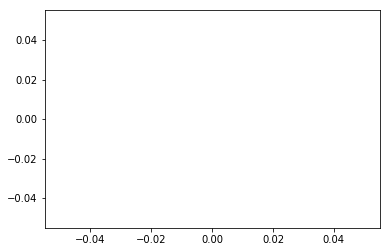

In [11]:
plt.plot(C_df.loc[session][1].values[6230:6248])
plt.plot(C_df.loc[session][36].values[6230:6248])
plt.show()

In [ ]:
plt.plot(cells_in_session[15][0:100].values)
plt.plot(cells_in_session[23][0:100].values)
plt.show()

plt.plot(reindexed[15].values[0:100])
plt.plot(reindexed[23].values[0:100])
plt.show()

In [11]:
def map_to_sparse_matrix(cell_pairs, orig_df_comparison, time_index):
    indicies_to_update = []
    if time_index%1000==0:
        print(time_index)
    for pair, pair_idx in zip(cell_pairs, range(len(cell_pairs))):
        if (orig_df_comparison.loc[time_index][pair[0]] == 1) and (orig_df_comparison.loc[time_index][pair[1]] == 1):
            indicies_to_update.append((time_index, pair_idx))
        else:
            pass
    return(indicies_to_update)

In [12]:
# analyze by session in parallel

coactivity_by_session = {}
for session in tqdm(list(grouped_raw_data.keys())):
    cells_to_drop = np.array([cell for cell in range(1, len(grouped_raw_data[session]['cell_contours'])+1) if 
                              len(np.array(np.where(grouped_raw_data[session]['for_dims'][cell]>0.6)[0]))<100])
    filtered_centers_of_mass = grouped_raw_data[session]['com'].drop(cells_to_drop, axis =0)
    com_distances = utils_jjm.get_pairwise_distance_by_session(filtered_centers_of_mass)

    ##get binned fluorescence and calc Jaccard scores
    #arguments are sample widths to bin and z score thresholds
    cells_in_session = C_df.loc[session].dropna(axis=1).drop('msCamFrame', axis=1)
    binned_fluorescence = cells_in_session.apply(utils_jjm.binning_function_uncrop, args=[1, 4])

    reindexed = binned_fluorescence.set_index(int(x) for x in np.linspace(0, len(binned_fluorescence)-1, len(binned_fluorescence)))
    
    cell_pairs = np.array([pair for pair in itertools.combinations(list(reindexed.columns), 2)])
    
    #create dictionary of cell pairs, keys are index in the list of pair combinations
    pairs_dict = {pair_idx:pair for (pair_idx , pair) in zip(range(len(cell_pairs)), cell_pairs)}
    
    coactivity_in_session_p = sparse.dok_matrix((len(reindexed), len(cell_pairs)))
    
    # search for indicies with coactivity
    p=Pool(9)
    indicies = [cell_indicies for cell_indicies in list(p.map(functools.partial(map_to_sparse_matrix, cell_pairs, reindexed), range(len(reindexed)))) if len(cell_indicies)>0]
    indicies_flattened = [indx for sublist in indicies for indx in sublist]
    
    p.close
    
    # update the coactivity matrix 
    for dok_index in indicies_flattened:
        coactivity_in_session_p[dok_index[0], dok_index[1]] = 1
    
    coactivity_by_session[session] =  {'coactivity_in_session': coactivity_in_session_p, 'cell_pairs':pairs_dict}
    
    

#save data to npz format 

directory_path='/projects/p30771/miniscope/analysis/OpenFieldAnalysis/spatial_clusters/zscore_4/'

for session in tqdm(list(grouped_raw_data.keys())):
    csr_matrix = coactivity_by_session[session]['coactivity_in_session'].tocsc()

    sparse.save_npz(directory_path+str(session)+".npz",
                      csr_matrix)

    pd.DataFrame(coactivity_by_session[session]['cell_pairs']).to_csv(directory_path+str(session)+".csv")

    #f.close()


  0%|          | 0/6 [00:00<?, ?it/s]

0
1000
3000
2000
4000
6000
5000


 17%|█▋        | 1/6 [21:30<1:47:30, 1290.12s/it]

0
1000
2000
3000
5000
4000


 33%|███▎      | 2/6 [24:55<1:04:18, 964.74s/it] 

0
1000
2000
3000
4000
5000
6000
7000


 50%|█████     | 3/6 [27:17<35:53, 717.79s/it]  

0
1000
3000
2000
4000
6000
5000


 67%|██████▋   | 4/6 [1:10:34<42:43, 1281.50s/it]

0
1000
2000
3000
5000
4000


 83%|████████▎ | 5/6 [1:13:18<15:46, 946.42s/it] 

0
1000
2000
3000
4000


100%|██████████| 6/6 [00:02<00:00,  2.20it/s]


# load saved data and plot spatial coordination index 

In [12]:
spatial_coordination_by_session = {}
for session in list(grouped_raw_data.keys()):
    print(session)
    session_coactivity = sparse.load_npz('/projects/p30771/miniscope/analysis/OpenFieldAnalysis/spatial_clusters/zscore_4/'+str(session)+'.npz')
    cell_pairs = pd.read_csv('/projects/p30771/miniscope/analysis/OpenFieldAnalysis/spatial_clusters/zscore_4/'+str(session)+'.csv')
# get indicies of small cells 
    cells_to_drop = np.array([cell for cell in range(1, len(grouped_raw_data[session]['cell_contours'])+1) if 
                          len(np.array(np.where(grouped_raw_data[session]['for_dims'][cell]>0.6)[0]))<100])
#compile and filter cell centers of mass
    filtered_centers_of_mass = grouped_raw_data[session]['com'].drop(cells_to_drop, axis =0)
    com_distances = utils_jjm.get_pairwise_distance_by_session(filtered_centers_of_mass)

# get one sided ks tests from h5 data set
    binnums = 50
    ks_one_sided_more = []
    ks_one_sided_less = []
    active_cell_ids = []
    active_cell_distances_list = []
    for time_point in tqdm(range(np.shape(session_coactivity)[0])):
        active_cells = [active_cell_pair_idx[1] for active_cell_pair_idx in np.argwhere(session_coactivity[time_point])]
        # might need to sort each cell pair to ensure smallest 1st
        cell_ids = np.array([sorted(cell_pairs[str(active_cell_idx)].values) for active_cell_idx in active_cells])
        active_cell_ids.append(cell_ids)
        active_cell_distances = np.array([com_distances[cell_id[0]][cell_id[1]].values[0] for cell_id in cell_ids])
        active_cell_distances_list.append(active_cell_distances)
        cum_results_coactive = stats.cumfreq(active_cell_distances, numbins=binnums, defaultreallimits=(0, 500))
        less_result = stats.kstest(cum_results_coactive.cumcount/len(active_cell_distances), 'norm', alternative='less')
        more_result = stats.kstest(cum_results_coactive.cumcount/len(active_cell_distances), 'norm', alternative='greater')
        ks_one_sided_more.append(more_result.pvalue)
        ks_one_sided_less.append(less_result.pvalue)
    
    spatial_coordination_by_session[session] = {'ks_one_sided_more' : ks_one_sided_more, 'ks_one_sided_less' : ks_one_sided_less, 
                                                'cell_ids': active_cell_ids, 'active_cell_distances': active_cell_distances_list}

GRIN009_H13_M59_S14


  0%|          | 0/6250 [00:00<?, ?it/s]/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
100%|██████████| 6250/6250 [00:27<00:00, 229.32it/s] 


GRIN018_H17_M41_S43


100%|██████████| 5250/5250 [00:09<00:00, 579.89it/s] 


GRIN018_H16_M13_S53


100%|██████████| 7250/7250 [00:09<00:00, 792.09it/s] 


GRIN011_H10_M19_S59


100%|██████████| 6250/6250 [01:28<00:00, 70.78it/s] 


GRIN012_H17_M32_S17


100%|██████████| 5209/5209 [00:09<00:00, 553.00it/s] 


GRIN012_H16_M57_S23


100%|██████████| 5000/5000 [00:15<00:00, 325.42it/s] 


In [14]:
f_path = 'ko_spatial_coordination_binsize_'+str(binnums)+'.h5'
f = h5py.File('/projects/p30771/miniscope/analysis/OpenFieldAnalysis/spatial_clusters/zscore_4/'+f_path)
for session in list(spatial_coordination_by_session.keys()):
    group = f.create_group(session)
    for measure in list(spatial_coordination_by_session[session].keys()):
        if measure not in ['cell_ids', 'active_cell_distances']:
            group.create_dataset(measure, data=np.array(spatial_coordination_by_session[session][measure]))
        elif measure == 'cell_ids':
            subgroup = group.create_group('cell_ids')
            for time_point in range(len(spatial_coordination_by_session[session][measure])):
                subgroup.create_dataset(str(time_point), data=spatial_coordination_by_session[session][measure][time_point])
        elif measure == 'active_cell_distances':
            subgroup = group.create_group('active_cell_distances')
            for time_point in range(len(spatial_coordination_by_session[session][measure])):
                subgroup.create_dataset(str(time_point), data=spatial_coordination_by_session[session][measure][time_point])
f.close()            
            

In [14]:
## compile coordination index info by session

triggered_activity_across_sessions = {}

for session in list(grouped_raw_data.keys()):
    ks_one_sided_less = spatial_coordination_by_session[session]['ks_one_sided_less']
    coord_index = np.nan_to_num([math.log(result, 100)*-1 for result in ks_one_sided_less])

    #put coordination index on time delta dataframe
    coord_index_df = pd.DataFrame(coord_index, columns=['spatial_coordination_index'])
    coord_index_df_time = coord_index_df.set_index(pd.to_timedelta(np.linspace(0, (len(coord_index_df)-1)*(1/5), len(coord_index_df)), unit='s'), drop=True)

    # bin by activity threshold (body_part, resting_time_threshold, active_time_threshold, crossing_threshold, resting_threshold, activity_threshold)
    binned_velocity_df = pd.DataFrame([dlc_utils.bin_by_activity_threshold(V_df.loc[session]['tail_base'], 80, 20, 1, 2, 3) for session in list(grouped_raw_data.keys())], index=list(grouped_raw_data.keys()))
    binned_velocity_df = binned_velocity_df.transpose()

    crossing_indicies = utils_jjm.select_trigger_regions(binned_velocity_df[session], 0.5, 0.5, 20)
    #inputs time_to_plot
    
    threshold_activity = utils_jjm.average_triggered_regions(V_df.loc[session]['tail_base'].values, crossing_indicies, 80)
    
    coordination_threshold_activity = utils_jjm.average_triggered_regions(coord_index, crossing_indicies, 80)
    
    triggered_activity_across_sessions[session] = pd.concat([threshold_activity, coordination_threshold_activity], axis=1, keys=['velocity', 'spatial_coordination'])

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
triggered_activity_across_sessions['GRIN013_H13_M33_S54']['spatial_coordination'].head()

# triggered_activity_across_sessions

In [15]:
## compile coordination index info by session
body_part = 'tail_base'
triggered_activity_across_sessions = {}

for session in list(grouped_raw_data.keys()):
    ks_one_sided_less = spatial_coordination_by_session[session]['ks_one_sided_less']
    coord_index = np.nan_to_num([math.log(result, 100)*-1 for result in ks_one_sided_less])

    #put coordination index on time delta dataframe
    coord_index_df = pd.DataFrame(coord_index, columns=['spatial_coordination_index'])
    coord_index_df_time = coord_index_df.set_index(pd.to_timedelta(np.linspace(0, (len(coord_index_df)-1)*(1/5), len(coord_index_df)), unit='s'), drop=True)

    # bin by activity threshold (body_part, resting_time_threshold, active_time_threshold, crossing_threshold, resting_threshold, activity_threshold)
    binned_velocity_df = pd.DataFrame([dlc_utils.bin_by_activity_threshold(V_df.loc[session][body_part], 80, 20, 1, 2, 3) for session in list(grouped_raw_data.keys())], index=list(grouped_raw_data.keys()))
    binned_velocity_df = binned_velocity_df.transpose()

    crossing_indicies = utils_jjm.select_trigger_regions(binned_velocity_df[session], 0.5, 0.5, 20)
    #inputs time_to_plot
    
    threshold_activity = utils_jjm.average_triggered_regions(V_df.loc[session][body_part].values, crossing_indicies, 80)
    
    coordination_threshold_activity = utils_jjm.average_triggered_regions(coord_index, crossing_indicies, 80)
    
    triggered_activity_across_sessions[session] = pd.concat([threshold_activity, coordination_threshold_activity], axis=1, keys=['velocity', 'spatial_coordination'])

In [16]:
#concat by mouse 
concacted_by_mouse = {}
for mouse in list(set([session[0:7] for session in list(triggered_activity_across_sessions.keys())])):
    dfs_by_mouse = []
    sessions = []
    for session in list(triggered_activity_across_sessions.keys()):
        if mouse in session:
            if not(triggered_activity_across_sessions[session].empty):
                means = triggered_activity_across_sessions[session].mean(axis=1, level=0)
                dfs_by_mouse.append(means)
                sessions.append(session)
    if len(dfs_by_mouse)>0:
        concacted_by_mouse[mouse] = pd.concat(dfs_by_mouse, axis=1, keys=sessions)
combined_by_mouse = pd.concat(list(concacted_by_mouse.values()), axis=1, keys=list(concacted_by_mouse.keys()))

In [17]:
combined_by_mouse_timedelta = combined_by_mouse.set_index(pd.to_timedelta(np.linspace(0, (len(combined_by_mouse)-1)*(1/5), len(combined_by_mouse)), unit='s'), drop=True)

In [18]:
resampled_for_plotting = combined_by_mouse_timedelta.resample('.4S').mean()

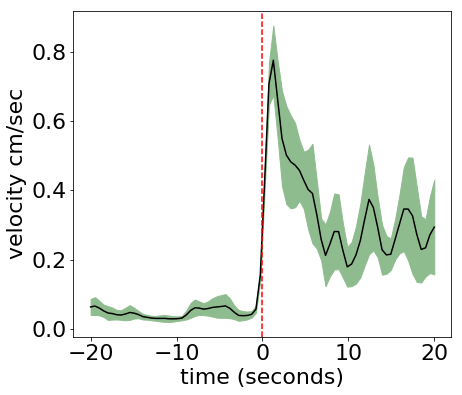

In [40]:
plt.rcParams.update({'font.size': 22})
df_to_plot = resampled_for_plotting
activity_measure = 'spatial_coordination'
x = np.linspace(-(len(df_to_plot)/2)*.5, (len(df_to_plot)/2)*.5, len(df_to_plot))
scale_f = 0.0868
mean=df_to_plot.mean(axis=1, level=2)['velocity'].values*scale_f
plt.plot(x, df_to_plot.mean(axis=1, level=2)['velocity'].values*scale_f, color='k')
std_error = ((df_to_plot.std(axis=1, level=2)['velocity'])/math.sqrt(df_to_plot.mean(axis=1, level=0).shape[1]))*scale_f
plt.fill_between(x, mean-std_error, mean+std_error, color='darkseagreen')
ax = plt.gca()
ax.set_ylabel('velocity cm/sec')
ax.set_xlabel('time (seconds)')
ax.axvline(x=(0), linestyle='--', color='r')
fig = plt.gcf()
fig.set_size_inches(7, 6)
#fig.draw()
#fig.savefig('/home/jma819/presentation_files/wt_velocity_spatial_coord_triggered.svg', transparent=True)
fig.subplots_adjust(left=0.15)
fig.savefig('/home/jma819/presentation_files/ko_velocity_spatial_coord_triggered.pdf', transparent=True)
plt.show()

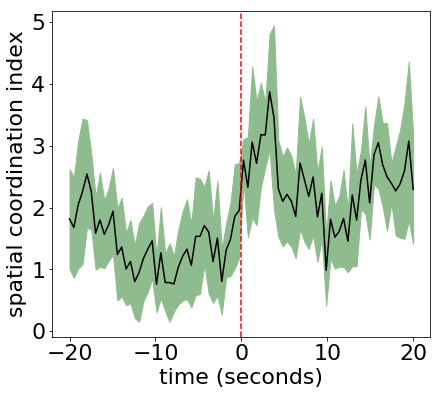

In [41]:
x = np.linspace(-(len(df_to_plot)/2)*.5, (len(df_to_plot)/2)*.5, len(df_to_plot))
mean = df_to_plot.mean(axis=1, level=2)[activity_measure].values
plt.plot(x, mean, color='k')
std_error = (df_to_plot.std(axis=1, level=2)[activity_measure])/math.sqrt(df_to_plot.mean(axis=1, level=0).shape[1]*1)
plt.fill_between(x, mean-std_error, mean+std_error, color='darkseagreen')
ax = plt.gca()
ax.set_ylabel('spatial coordination index')
ax.set_xlabel('time (seconds)')
ax.axvline(x=0, linestyle='--', color='r')
fig = plt.gcf()
fig.set_size_inches(7, 6)
#fig.draw()
#fig.savefig('.svg')
fig.subplots_adjust(left=0.15)
fig.savefig('/home/jma819/presentation_files/ko_spatial_coord_spatial_coord_triggered.pdf', transparent=True)
plt.show()

In [68]:
spatial_index_correlations = []
spatial_index_correlations_dict = {}
for session in list(grouped_raw_data.keys()):
    print(session)
    coordination_index = np.nan_to_num([math.log(result, 100)*-1 for result in spatial_coordination_by_session[session]['ks_one_sided_less']])
    velocity = V_df.loc[session]['tail_base'].values[:len(coordination_index)]
    if len(coordination_index)<=len(velocity):
        spatial_index_correlations.append(stats.pearsonr(coordination_index, velocity)[0])
        spatial_index_correlations_dict[session] = stats.pearsonr(coordination_index, velocity)[0]
    else:
        spatial_index_correlations.append(stats.pearsonr(coordination_index[:len(velocity)], velocity)[0])
        spatial_index_correlations_dict[session] = stats.pearsonr(coordination_index[:len(velocity)], velocity)[0]

#concat by mouse 
correlations_concacted_by_mouse = {}
for mouse in list(set([session[0:7] for session in list(spatial_index_correlations_dict.keys())])):
    correlations_by_mouse = []
    sessions = []
    for session in list(spatial_index_correlations_dict.keys()):
        if mouse in session:
            if spatial_index_correlations_dict[session]:
                means = spatial_index_correlations_dict[session]
                correlations_by_mouse.append(means)
                sessions.append(session)
    if len(correlations_by_mouse)>0:
        correlations_concacted_by_mouse[mouse] = np.mean(correlations_by_mouse)

means_by_mouse = [value for value in correlations_concacted_by_mouse.values()]
np.mean(np.array([value for value in correlations_concacted_by_mouse.values()]))

GRIN009_H13_M59_S14
GRIN018_H17_M41_S43
GRIN018_H16_M13_S53
GRIN011_H10_M19_S59
GRIN012_H17_M32_S17
GRIN012_H16_M57_S23


0.11291834887321828

In [70]:
means_by_mouse

[0.026046308991659307,
 0.0551927415216666,
 0.2237641541425582,
 0.14667019083698896]